In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import TranslationDataset
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np
import re 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
import math
import time

In [4]:
!pip install sacrebleu

    100% |████████████████████████████████| 61kB 3.8MB/s ta 0:00:01


In [5]:
!python -m spacy download en


    Linking successful
    /miniconda3/lib/python3.6/site-packages/en_core_web_sm -->
    /miniconda3/lib/python3.6/site-packages/spacy/data/en

    You can now load the model via spacy.load('en')



In [6]:
!python3 -m spacy download fr


    Linking successful
    /miniconda3/lib/python3.6/site-packages/fr_core_news_sm -->
    /miniconda3/lib/python3.6/site-packages/spacy/data/fr

    You can now load the model via spacy.load('fr')



In [7]:
SRC = Field(tokenize = "spacy",
            tokenizer_language="en",
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize = "spacy",
            tokenizer_language="fr",
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

In [8]:
import os
import xml.etree.ElementTree as ET
import glob
import io
import codecs


In [41]:
# class modified from the original code in pytorch to be able to load the 2014 IWSLT dataset
class IWSLT(TranslationDataset):
    """The IWSLT 2014 TED talk translation task"""

    base_url = 'https://wit3.fbk.eu/archive/2014-01//texts/{}/{}/{}.tgz'
    name = 'iwslt'
    base_dirname = '{}-{}'

    @classmethod
    def splits(cls, exts, fields, root='.data',
               train='train', validation='IWSLT14.TED.dev2010',
               test='IWSLT14.TED.tst2011', max_len=20, **kwargs):
        """Create dataset objects for splits of the IWSLT dataset.
        Arguments:
            exts: A tuple containing the extension to path for each language.
            fields: A tuple containing the fields that will be used for data
                in each language.
            root: Root dataset storage directory. Default is '.data'.
            train: The prefix of the train data. Default: 'train'.
            validation: The prefix of the validation data. Default: 'val'.
            test: The prefix of the test data. Default: 'test'.
            Remaining keyword arguments: Passed to the splits method of
                Dataset.
        """
        cls.dirname = cls.base_dirname.format(exts[0][1:], exts[1][1:])
        cls.urls = [cls.base_url.format(exts[0][1:], exts[1][1:], cls.dirname)]
        check = os.path.join(root, cls.name, cls.dirname)
        path = cls.download(root, check=check)

        train = '.'.join([train, cls.dirname])
        validation = '.'.join([validation, cls.dirname])
        if test is not None:
            test = '.'.join([test, cls.dirname])

        if not os.path.exists(os.path.join(path, train) + exts[0]):
            cls.clean(path, exts=exts, max_len=max_len)

        train_data = None if train is None else cls(
            os.path.join(path, train), exts, fields, **kwargs)
        val_data = None if validation is None else cls(
            os.path.join(path, validation), exts, fields, **kwargs)
        test_data = None if test is None else cls(
            os.path.join(path, test), exts, fields, **kwargs)
        return tuple(d for d in (train_data, val_data, test_data)
                     if d is not None)

    @staticmethod
    def clean(path, exts, max_len=20, max_lines=200000, lower=True, remove_special_caracters=True):
        for f_xml in glob.iglob(os.path.join(path, '*.xml')):
            print(f_xml)
            f_txt = os.path.splitext(f_xml)[0]
            with codecs.open(f_txt, mode='w', encoding='utf-8') as fd_txt:
                root = ET.parse(f_xml).getroot()[0]
                for doc in root.findall('doc'):
                    for e in doc.findall('seg'):
                        s = e.text
                        if lower:
                            s = s.lower()
                        if remove_special_caracters:
                            s = re.sub(r"([.!?])", r" \1", s)
                            s = re.sub(r"[\W+\d+]+", r" ", s)
                        fd_txt.write(s.strip() + '\n')

        xml_tags = ['<url', '<keywords', '<talkid', '<description',
                    '<reviewer', '<translator', '<title', '<speaker']
        lang_src = exts[0][1:]
        lang_trg = exts[1][1:]
        l_lines = []
        train_files = [os.path.join(path, 'train.tags.en-fr.fr'),os.path.join(path, 'train.tags.en-fr.en')]
        for nb_f,f_orig in enumerate(train_files):
            print(f_orig)
            lang = f_orig.split(".")[-1]
            print("lang :", lang)
            f_txt = f_orig.replace('.tags', '')
            with codecs.open(f_txt, mode='w', encoding='utf-8') as fd_txt, \
                    io.open(f_orig, mode='r', encoding='utf-8') as fd_orig:
                inc=0
                for nb_l,l in enumerate(fd_orig):
                    if inc>max_lines:
                        break;
                    
                    if nb_f==0:
                        if len(l.split(" "))<=max_len:
                            if not any(tag in l for tag in xml_tags):
                                s = l
                                if lower:
                                    s = s.lower()
                                if remove_special_caracters:
                                    s = re.sub(r"([.!?])", r" \1", s)
                                    s = re.sub(r"[\W+\d+]+", r" ", s)
                                fd_txt.write(s.strip() + '\n')
                                inc+=1
                                l_lines.append(nb_l)
                    else:
                        if nb_l in l_lines:
                            s = l
                            if lower:
                                s = s.lower()
                            if remove_special_caracters:
                                s = re.sub(r"([.!?])", r" \1", s)
                                s = re.sub(r"[\W+\d+]+", r" ", s)
                            fd_txt.write(s.strip() + '\n')
                            inc+=1
                        


In [42]:
train_data, valid_data, test_data = IWSLT.splits(exts = ('.en', '.fr'), 
                                                    fields = (SRC, TRG), max_len=25)

downloading en-fr.tgz


en-fr.tgz: 100%|██████████| 20.9M/20.9M [00:03<00:00, 6.82MB/s]


.data/iwslt/en-fr/IWSLT14.TED.tst2011.en-fr.fr.xml
.data/iwslt/en-fr/IWSLT14.TED.tst2010.en-fr.en.xml
.data/iwslt/en-fr/IWSLT14.TED.tst2010.en-fr.fr.xml
.data/iwslt/en-fr/IWSLT14.TED.tst2011.en-fr.en.xml
.data/iwslt/en-fr/IWSLT14.TED.dev2010.en-fr.en.xml
.data/iwslt/en-fr/IWSLT14.TED.tst2012.en-fr.fr.xml
.data/iwslt/en-fr/IWSLT14.TED.dev2010.en-fr.fr.xml
.data/iwslt/en-fr/IWSLT14.TED.tst2012.en-fr.en.xml
.data/iwslt/en-fr/train.tags.en-fr.fr
lang : fr
.data/iwslt/en-fr/train.tags.en-fr.en
lang : en


In [43]:
print("length train :",len(train_data))
print("length val :",len(valid_data))
print("length test :",len(test_data))


length train : 141119
length val : 887
length test : 818


In [44]:
example_idx = 12390

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {" ".join(src)}')
print(f'trg = {" ".join(trg)}')

src = and if you zoom in times you ll see it looks like a rug
trg = et si vous zoomez fois vous verrez que ça ressemble à un tapis


In [45]:
example_idx = 500

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {" ".join(src)}')
print(f'trg = {" ".join(trg)}')

src = you ve seen recently corn to ethanol is just a bad experiment
trg = vous avez pu voir récemment que la transformation du maïs en éthanol n est rien qu une mauvaise expérience


Build the vocabulary.

In [58]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

Define the device.

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Create the iterators.

In [60]:
BATCH_SIZE = 256

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

## Building the Seq2Seq Model

### Encoder

First, we'll build the encoder. Similar to the previous model, we only use a single layer GRU, however we now use a *bidirectional RNN*. With a bidirectional RNN, we have two RNNs in each layer. A *forward RNN* going over the embedded sentence from left to right (shown below in green), and a *backward RNN* going over the embedded sentence from right to left (teal). All we need to do in code is set `bidirectional = True` and then pass the embedded sentence to the RNN as before. 

In [61]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

### Attention

Next up is the attention layer. This will take in the previous hidden state of the decoder, $s_{t-1}$, and all of the stacked forward and backward hidden states from the encoder, $H$. The layer will output an attention vector, $a_t$, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1.

In [62]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)

### Decoder

In [63]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

### Seq2Seq


In [64]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

## Training the Seq2Seq Model

We initialise our parameters, encoder, decoder and seq2seq model (placing it on the GPU if we have one). 

In [98]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
ENC_HID_DIM = 256
DEC_HID_DIM = 256
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

We use a simplified version of the weight initialization scheme used in the paper. Here, we will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.01)$.

In [99]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(23342, 128)
    (rnn): GRU(128, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=768, out_features=256, bias=True)
      (v): Linear(in_features=256, out_features=1, bias=False)
    )
    (embedding): Embedding(29362, 128)
    (rnn): GRU(640, 256)
    (fc_out): Linear(in_features=896, out_features=29362, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

Calculate the number of parameters. We get an increase of almost 50% in the amount of parameters from the last model. 

In [69]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 34,694,834 trainable parameters


We create an optimizer.

In [70]:
optimizer = optim.Adam(model.parameters())

We initialize the loss function.

In [71]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

We then create the training loop...

In [72]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

...and the evaluation loop, remembering to set the model to `eval` mode and turn off teaching forcing.

In [73]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Finally, define a timing function.

In [74]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Then, we train our model, saving the parameters that give us the best validation loss.

In [28]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')
train_loss_list = []
val_loss_list = []
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    train_loss_list.append(train_loss)
    val_loss_list.append(valid_loss)
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'en_fr-translation_model1.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 10m 48s
	Train Loss: 6.173 | Train PPL: 479.593
	 Val. Loss: 6.428 |  Val. PPL: 618.851
Epoch: 02 | Time: 10m 48s
	Train Loss: 5.218 | Train PPL: 184.525
	 Val. Loss: 5.900 |  Val. PPL: 364.955
Epoch: 03 | Time: 10m 47s
	Train Loss: 4.399 | Train PPL:  81.375
	 Val. Loss: 5.719 |  Val. PPL: 304.658
Epoch: 04 | Time: 10m 49s
	Train Loss: 3.829 | Train PPL:  46.028
	 Val. Loss: 5.598 |  Val. PPL: 269.975
Epoch: 05 | Time: 10m 46s
	Train Loss: 3.461 | Train PPL:  31.847
	 Val. Loss: 5.588 |  Val. PPL: 267.085
Epoch: 06 | Time: 10m 47s
	Train Loss: 3.185 | Train PPL:  24.177
	 Val. Loss: 5.527 |  Val. PPL: 251.334
Epoch: 07 | Time: 10m 47s
	Train Loss: 2.969 | Train PPL:  19.464
	 Val. Loss: 5.635 |  Val. PPL: 280.164
Epoch: 08 | Time: 10m 47s
	Train Loss: 2.817 | Train PPL:  16.722
	 Val. Loss: 5.605 |  Val. PPL: 271.697
Epoch: 09 | Time: 10m 49s
	Train Loss: 2.692 | Train PPL:  14.766
	 Val. Loss: 5.609 |  Val. PPL: 272.798
Epoch: 10 | Time: 10m 47s
	Train Loss: 2.588 |

[]

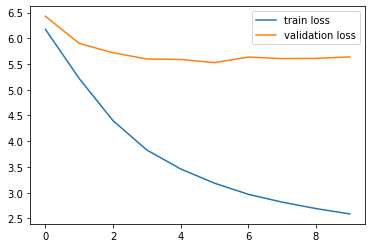

In [36]:
train_loss_list = [6.173, 5.218, 4.399, 3.829, 3.461, 3.185, 2.969, 2.817, 2.692, 2.588]
val_loss_list = [6.428, 5.900, 5.719, 5.598, 5.588, 5.527, 5.635, 5.605, 5.609, 5.638]
plt.plot(train_loss_list, label="train loss")
plt.plot(val_loss_list, label="validation loss")
plt.legend()
plt.plot()

Finally, we test the model on the test set using these "best" parameters.

In [100]:
if device==torch.device("cuda"):
    model.load_state_dict(torch.load('en_fr-translation_model1.pt'))
else:
    model.load_state_dict(torch.load('en_fr-translation_model1.pt', map_location=torch.device('cpu')))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.636 | Test PPL: 103.093 |


# Inference :

## Greedy decoding :

In [101]:
def translate_sentence_greedy(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)

        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [102]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
    fig.colorbar(cax)

    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [40]:
l = random.sample(range(len(train_data)), 5)

for example_idx in l:
    src = vars(train_data.examples[example_idx])['src']
    trg = vars(train_data.examples[example_idx])['trg']
    translation, attentiaon = translate_sentence_greedy(src, SRC, TRG, model, device)

    print(f'src = {" ".join(src)}')
    print(f'trg = {" ".join(trg)}')
    print(f'predicted trg = {" ".join(translation)}')
    print("\n")


src = why should it work and is this something to do with human beings
trg = pourquoi ça devrait marcher et est ce que cela a à voir avec les êtres humains
predicted trg = pourquoi devrions ce travail et c est quelque chose avec les humains humains <eos>


src = well one line of thinking is let s take this profit and redeploy it into social problems
trg = eh bien une façon de voir les choses consiste à dire prenons ce bénéfice et redéployons le vers les problèmes sociaux
predicted trg = eh bien une question de pensée est est ce que nous <unk> et ce et et les problèmes sociaux <eos>


src = so this cyber sea which we know endlessly is the fundamental piece of radical openness is very much under threat as well
trg = cette cyber mer dont nous savons sans cesse qu elle est la pièce fondamentale de la transparence radicale est donc vraiment menacée aussi
predicted trg = donc ce mer de ce que nous savons est est est le élément de l radicale radicale est très bien <eos>


src = i m talking ab

In [79]:
example_idx = 210

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {" ".join(src)}')
print(f'trg = {" ".join(trg)}')

src = and it s very much an in the moment activity that they re engaged in
trg = et ils sont vraiment plongés dans une activité spontanée


In [80]:
translation, attentiaon = translate_sentence_greedy(src, SRC, TRG, model, device)

print(f'predicted trg = {" ".join(translation)}')

predicted trg = et c est très dans dans l activité dans laquelle l on s intéressent <eos>


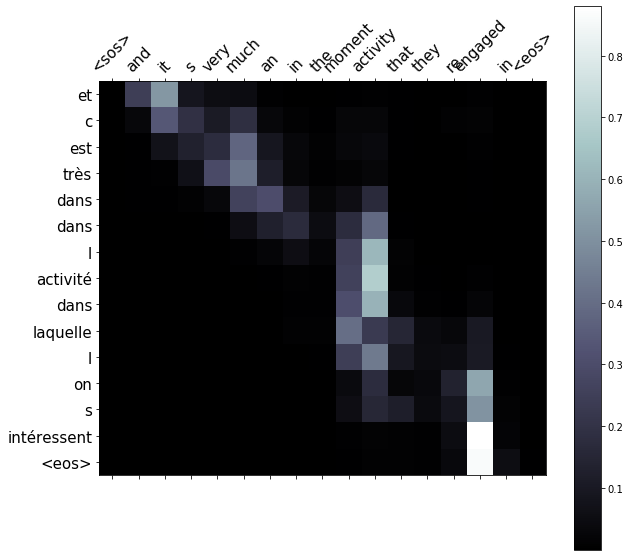

In [81]:
display_attention(src, translation, attentiaon)

In [47]:
l = random.sample(range(len(valid_data)), 5)

for example_idx in l:
    src = vars(valid_data.examples[example_idx])['src']
    trg = vars(valid_data.examples[example_idx])['trg']
    translation, attentiaon = translate_sentence_greedy(src, SRC, TRG, model, device)

    print(f'src = {" ".join(src)}')
    print(f'trg = {" ".join(trg)}')
    print(f'predicted trg = {" ".join(translation)}')
    print("\n")


src = you know i never thought that i d end up working at microsoft
trg = vous savez je n aurais jamais cru que je finirais par travailler chez microsoft
predicted trg = vous savez je ne pensais jamais pensé que je commençais à microsoft <eos>


src = he doesn t have a piece of paper he doesn t have a pencil he doesn t have a tape recorder
trg = il n avait pas de papier pas de crayon il n avait pas de dictaphone
predicted trg = il n a pas un morceau de papier il n a pas un crayon il n a pas un un de <eos>


src = and as these tools become more physical more aware of their motion aware of each other and aware of the nuance of how we move them we can start to explore some new and fun interaction styles
trg = a mesure que ces outils deviennent de plus en plus physiques davantage conscients de leur mouvement de la présence des autres et conscients des nuances dans notre façon de les déplacer on peut commencer à étudier de nouveaux styles d interactions amusants
predicted trg = et ces outil

### BLUE SCORE

Previously we have only cared about the loss/perplexity of the model. However there metrics that are specifically designed for measuring the quality of a translation - the most popular is BLEU. Without going into too much detail, BLEU looks at the overlap in the predicted and actual target sequences in terms of their n-grams. It will give us a number between 0 and 1 for each sequence, where 1 means there is perfect overlap, i.e. a perfect translation, although is usually shown between 0 and 100. BLEU was designed for multiple candidate translations per source sequence, however in this dataset we only have one candidate per source.

We define a calculate_bleu function which calculates the BLEU score over a provided target dataset. This function creates a corpus of the actual and predicted translation for each source sentence and then calculates the BLEU score.

In [48]:
import sacrebleu

def calculate_bleu_greedy(data, model, SRC, TRG, device):
    
    trgs = []
    pred_trgs = []
    
    for i in range(len(data)):
        
        src = vars(data.examples[i])['src']
        trg = vars(data.examples[i])['trg']
        output_words, attention = translate_sentence_greedy(src, SRC, TRG, model, device)
        #cut off <eos> token
        pred_trg = output_words[:-1]
        pred_trg_sentence = ' '.join(pred_trg)
        pred_trgs.append(pred_trg_sentence)
        trgs.append(" ".join(trg))
    
    bleu = sacrebleu.corpus_bleu(pred_trgs, [trgs])

    return bleu.score

In [49]:
calculate_bleu_greedy(valid_data, model, SRC, TRG, device)

10.65783110863191

In [50]:
calculate_bleu_greedy(test_data, model, SRC, TRG, device)

16.98376106679149

## BEAM SEARCH + Length normalisation :

In [108]:
from queue import PriorityQueue
import operator

class BeamSearchNode(object):
    def __init__(self, hiddenstate, previousNode, wordId, logProb, length):
        '''
        :param hiddenstate:
        :param previousNode:
        :param wordId:
        :param logProb:
        :param length:
        '''
        self.h = hiddenstate
        self.prevNode = previousNode
        self.wordid = wordId
        self.logp = logProb
        self.leng = length

    def eval(self, length_normalisation):

        if length_normalisation:
            return self.logp / float(self.leng)
        else:
            return self.logp




def beam_decode(model, sentence, src_field, trg_field, length_normalisation=True, beam_width=10, topk=1 ):
    '''
    :param target_tensor: target indexes tensor of shape [B, T] where B is the batch size and T is the maximum length of the output sentence
    :param decoder_hidden: input tensor of shape [1, B, H] for start of the decoding
    :param encoder_outputs: if you are using attention mechanism you can pass encoder outputs, [T, B, H] where T is the maximum length of input sentence
    :param beam_widh : the width of the beam search
    :param topk : how many sentence do you want to generate
    :return: decoded_batch
    '''

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)

       
    decoder_input = torch.LongTensor([trg_field.vocab.stoi[trg_field.init_token]]).to(device)
    # Number of sentence to generate
    endnodes = []
    number_required = min((topk + 1), topk - len(endnodes))

    # starting node -  hidden vector, previous node, word id, logp, length
    node = BeamSearchNode(hidden, None, decoder_input, 0, 1)
    nodes = PriorityQueue()

    # start the queue
    nodes.put((-node.eval(length_normalisation=length_normalisation), node))
    qsize = 1
    
    # start beam search
    while True:
        # give up when decoding takes too long
        if qsize > 2000: break

        # fetch the best node
        score, n = nodes.get()
        decoder_input = n.wordid
        decoder_hidden = n.h

        if n.wordid.item() == trg_field.vocab.stoi[trg_field.eos_token] and n.prevNode != None:
            endnodes.append((score, n))
            # if we reached maximum # of sentences required
            if len(endnodes) >= number_required:
                break
            else:
                continue

        # decode for one step using decoder
        with torch.no_grad():
            decoder_output, decoder_hidden, attention = model.decoder(decoder_input, decoder_hidden, encoder_outputs)
        #decoder_output, decoder_hidden = model.decoder(decoder_input, decoder_hidden.squeeze(0), encoder_output)

        # PUT HERE REAL BEAM SEARCH OF TOP
        log_prob, indexes = torch.topk(decoder_output, beam_width)
        nextnodes = []

        for new_k in range(beam_width):
            decoded_t = indexes[0][new_k].view(1)
            log_p = log_prob[0][new_k].item()

            node = BeamSearchNode(decoder_hidden, n, decoded_t, n.logp + log_p, n.leng + 1)
            score = -node.eval(length_normalisation=length_normalisation)
            nextnodes.append((score, node))

        # put them into queue
        for i in range(len(nextnodes)):
            score, nn = nextnodes[i]
            nodes.put((score, nn))
            # increase qsize
        qsize += len(nextnodes) - 1

    # choose nbest paths, back trace them
    if len(endnodes) == 0:
        endnodes = [nodes.get() for _ in range(topk)]

    n_best_sentences = []
    for score, n in sorted(endnodes, key=operator.itemgetter(0)):
        decoded_sentence_idx = []
        decoded_sentence_idx.append(n.wordid.item())
        # back trace
        while n.prevNode != None:
            n = n.prevNode
            decoded_sentence_idx.append(n.wordid.item())

        decoded_sentence_idx = decoded_sentence_idx[::-1]
        decoded_sentence = [trg_field.vocab.itos[i] for i in decoded_sentence_idx]
        n_best_sentences.append(decoded_sentence[1:])

    return n_best_sentences

In [85]:
l = random.sample(range(len(train_data)), 5)

for example_idx in l:
    src = vars(train_data.examples[example_idx])['src']
    trg = vars(train_data.examples[example_idx])['trg']
    print("source sentence : "," ".join(src))
    print("target sentence : "," ".join(trg))
    predicted_beam = beam_decode(model, src, SRC, TRG, length_normalisation=True, beam_width=20, topk=1)
    predicted_greedy, _ = translate_sentence_greedy(src, SRC, TRG, model, device)
    print("beam search decoded sentence : "," ".join(predicted_beam[0]))
    print("greedy decoded sentence : "," ".join(predicted_greedy))
    print("\n")


source sentence :  so what does the happiest man in the world look like
target sentence :  alors à quoi ressemble l homme le plus heureux du monde
beam search decoded sentence :  donc que est le plus heureux du monde ressemble à monde <eos>
greedy decoded sentence :  donc que est le plus heureux de monde monde ressemble à monde <eos>


source sentence :  and that animated graphics can make a difference
target sentence :  et je vous ai dit que les graphiques animés peuvent faire la différence
beam search decoded sentence :  et ce tableau graphiques peut peut faire une différence <eos>
greedy decoded sentence :  et ce tableau graphiques peut peut faire une différence <eos>


source sentence :  this is a deep question
target sentence :  c est une question profonde
beam search decoded sentence :  c est une question question <eos>
greedy decoded sentence :  c est une question question <eos>


source sentence :  i had an explosion
target sentence :  j avais provoqué une explosion
beam search

In [86]:
l = random.sample(range(len(valid_data)), 5)

for example_idx in l:
    src = vars(train_data.examples[example_idx])['src']
    trg = vars(train_data.examples[example_idx])['trg']
    print("source sentence : "," ".join(src))
    print("target sentence : "," ".join(trg))
    predicted_beam = beam_decode(model, src, SRC, TRG, length_normalisation=True, beam_width=20, topk=1)
    predicted_greedy, _ = translate_sentence_greedy(src, SRC, TRG, model, device)
    print("beam search decoded sentence : "," ".join(predicted_beam[0]))
    print("greedy decoded sentence : "," ".join(predicted_greedy))
    print("\n")


source sentence :  and by the way when i graduated from mit i thought the worst and silliest thing to do would be to go to paris for six years
target sentence :  d ailleurs quand j ai eu mon diplôme du mit je pensais que le pire et le plus stupide aurait été d aller à paris pendant six ans
beam search decoded sentence :  et quand quand j ai reçu du mit j j ai dit la pire
greedy decoded sentence :  et quand quand j ai reçu du mit j ai pensé que la pire et <unk> <unk> et pour aller à paris pour sept ans <eos>


source sentence :  and plant
target sentence :  et le faire saluer
beam search decoded sentence :  et les hôtes <eos>
greedy decoded sentence :  et les hôtes <eos>


source sentence :  i must confess there s kind of a third motivation as well
target sentence :  je dois avouer il y a aussi une troisième motivation
beam search decoded sentence :  je dois avouer qu il y a une sorte de motivation <eos>
greedy decoded sentence :  je dois avouer qu il y a une sorte de troisième motivati

In [92]:
import sacrebleu
def calculate_bleu_beam_search(data, model, SRC, TRG, device, length_normalisation=True, beam_width=20):
    
    trgs = []
    pred_trgs = []
    
    for i in range(len(data)):
        
        src = vars(data.examples[i])['src']
        #print(src)
        trg = vars(data.examples[i])['trg']
        try :
            output_words = beam_decode(model, src, SRC, TRG, length_normalisation=length_normalisation, 
                                       beam_width=beam_width, topk=1)
            pred_trg = output_words[0][:-1]
            #print(pred_trg)
            pred_trg_sentence = ' '.join(pred_trg)
            pred_trgs.append(pred_trg_sentence)
            trgs.append(" ".join(trg))
        except(TypeError):
            print("pass due to unknown TypeError")
        
    
    bleu = sacrebleu.corpus_bleu(pred_trgs, [trgs])

    return bleu.score

### Validation and test score with length penalisation :

In [104]:
beam_width_list = [10,20,50,100]
for beam_width in beam_width_list:
    start_time = time.time()
    s = calculate_bleu_beam_search(valid_data, model, SRC, TRG, device, length_normalisation=True, beam_width=beam_width)
    end_time = time.time()
    print("beam width = ",beam_width)
    print("bleu score =",s)
    print("execution time :",end_time-start_time)
    print("\n")

beam width =  10
bleu score = 8.83953422570629
execution time : 529.6709139347076


pass due to unknown TypeError
pass due to unknown TypeError
beam width =  20
bleu score = 8.171279421584828
execution time : 332.4088909626007


pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
beam width =  50
bleu score = 6.860691991139817
execution time : 180.82362031936646


pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
beam width =  100
bleu score = 5.410254378627553
execution time : 129.20666193962097




In [105]:
beam_width_list = [10,20,50,100]
for beam_width in beam_width_list:
    start_time = time.time()
    s = calculate_bleu_beam_search(test_data, model, SRC, TRG, device, length_normalisation=True, beam_width=beam_width)
    end_time = time.time()
    print("beam width = ",beam_width)
    print("bleu score =",s)
    print("execution time :",end_time-start_time)
    print("\n")

beam width =  10
bleu score = 15.448628058694181
execution time : 437.87719798088074


beam width =  20
bleu score = 14.918149412532347
execution time : 262.2862720489502


pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
beam width =  50
bleu score = 13.345503964005122
execution time : 144.9031901359558


pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
beam width =  100
bleu score = 11.301024687657817
execution time : 106.8429479598999




### Validation and test score without length penalisation :

In [106]:
beam_width_list = [10,20,50,100]
for beam_width in beam_width_list:
    start_time = time.time()
    s = calculate_bleu_beam_search(valid_data, model, SRC, TRG, device, length_normalisation=False, beam_width=beam_width)
    end_time = time.time()
    print("beam width = ",beam_width)
    print("bleu score =",s)
    print("execution time :",end_time-start_time)
    print("\n")

beam width =  10
bleu score = 10.644855000201375
execution time : 112.03231716156006


pass due to unknown TypeError
beam width =  20
bleu score = 10.65700976630921
execution time : 99.52241802215576


pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
beam width =  50
bleu score = 10.666781366584228
execution time : 113.8241720199585


pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
beam width =  100
bleu score = 8.950407712786904
execution time : 117.0206310749054




In [109]:
beam_width_list = [10,20,50,100]
for beam_width in beam_width_list:
    start_time = time.time()
    s = calculate_bleu_beam_search(test_data, model, SRC, TRG, device, length_normalisation=False, beam_width=beam_width)
    end_time = time.time()
    print("beam width = ",beam_width)
    print("bleu score =",s)
    print("execution time :",end_time-start_time)
    print("\n")

beam width =  10
bleu score = 16.933839699914913
execution time : 89.98872113227844


beam width =  20
bleu score = 16.96990611340291
execution time : 87.48685383796692


pass due to unknown TypeError
pass due to unknown TypeError
beam width =  50
bleu score = 16.993190622779284
execution time : 93.13923382759094


pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
pass due to unknown TypeError
beam width =  100
bleu score = 15.940887078369652
execution time : 99.37949013710022


